# Swiss Roll Embedding in 2D

In this document we test the benefits of using multi-time-steps Markov transition matrix as inputs to the KL divergence optimization solved by t-SNE. When constructing a proximity matrix for t-SNE, one might consider keeping bandwidths small for the Gaussian kernel, but then taking higher powers, $P^T$, of the corresponding conditional probability matrix, $P = P_{j|i}$. Varying powers of $P$ allow for studing the geometry of the data at different scales.

## 0. Setup


In [297]:
import sys
import os
#limit the number of threds numpy/scipy are using
os.environ["OMP_NUM_THREADS"] = "4"
nthreads = 4

import time 
import pickle
import numpy as npd
import multiprocessing as mp

# Custom pyscripts
maindir = '/home/lanhuong/Projects/ManifoldLearning/DiffusionTSNE'
curdir = os.getcwd()
#maindir = '../'
os.chdir(maindir)

from diffusion_tsne import diffusion_tsne

from plotting import *
from generate_data import *
from utils import *
from metrics import *

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.titlesize'] = 30
mpl.rcParams['axes.titlesize']   = 30
mpl.rcParams['axes.labelsize']   = 20
mpl.rcParams['xtick.labelsize']  = 16
mpl.rcParams['ytick.labelsize']  = 16
mpl.rc('text', usetex=True)

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [553]:
X.shape

(3000, 3)

In [20]:
#np.show_config()

## 1. Swiss Roll uniformly sampled

In [555]:
# uniformly sampled
np.random.seed(123)
n_points = 3000; noise = 0
X, color, y = swiss_roll(n_points, noise)
GX = distance2(np.vstack((color, y)).T)
X.shape
Xtruth = np.array([color, y]).T
Xtruth.shape

(3000, 2)

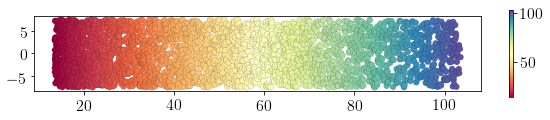

In [550]:
p0 = plot2D(np.vstack((color, y)).T, label=color, figsize=(10, 2))
plt.axes().set_aspect(1.0)

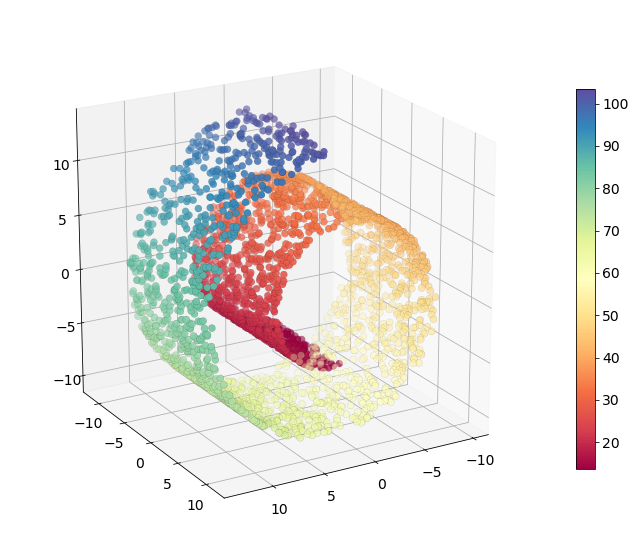

In [139]:
p = plot3D(X, label=color)

# 1.0 PCA

In [145]:
import sklearn.decomposition # PCA
start = time.time()
pca_operator = sklearn.decomposition.PCA(n_components=2)
Y_pca = pca_operator.fit_transform(X)
end = time.time()
print("Embedded PCA in {:.2f} seconds.".format(end-start))
Y_pca.shape

Embedded PCA in 0.00 seconds.


(3000, 2)

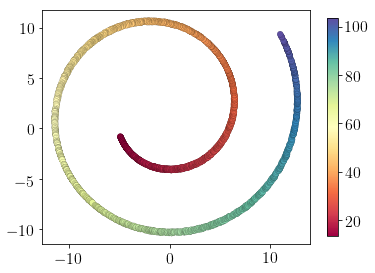

In [542]:
plot2D(Y_pca, label = color,figsize=(6, 5))
plt.axes().set_aspect(1.0)

In [ ]:
len(score_pca)

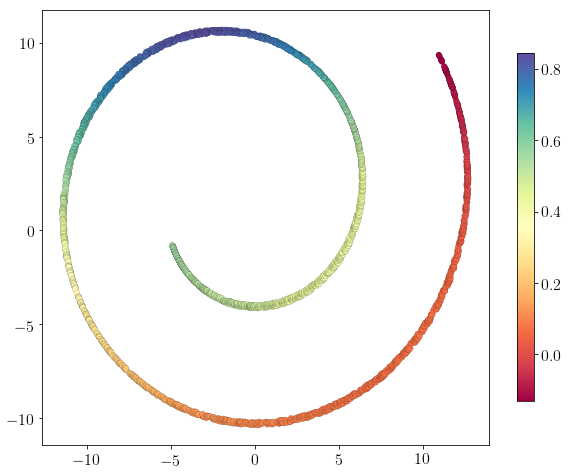

In [369]:
score_pca = coranking_quality(X, Y_pca, 'QNK', 1, 250)
rho_pca = geo_rho(X, Y_pca, GX = GX)
plot2D(Y_pca, label = rho_pca,figsize=(10, 8))

In [359]:
print(np.mean(rho_pca))
print(np.var(rho_pca))

0.4123862563409913
0.06883024271263131


## 1.1 PHATE

In [140]:
import phate
start = time.time()
phate_operator = phate.PHATE(n_jobs=-2)
Y_phate = phate_operator.fit_transform(X)
end = time.time()
print("Embedded with PHATE in {:.2f} seconds.".format(end-start))

Calculating PHATE...
  Running PHATE on 3000 cells and 3 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.27 seconds.
    Calculating affinities...
    Calculated affinities in 0.16 seconds.
  Calculated graph and diffusion operator in 0.44 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.94 seconds.
    Calculating KMeans...
    Calculated KMeans in 22.74 seconds.
  Calculated landmark operator in 25.90 seconds.
  Calculating optimal t...
    Automatically selected t = 46
  Calculated optimal t in 1.43 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.40 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 28.89 seconds.
Calculated PHATE in 58.09 seconds.
Embedded with PHATE in 58.10 seconds.


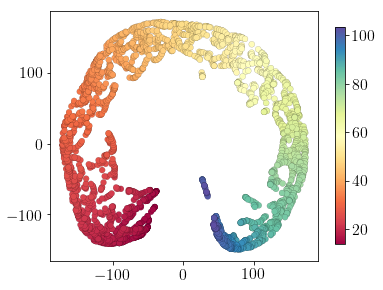

In [543]:
plot2D(Y_phate, label = color,figsize=(6, 5))
plt.axes().set_aspect(1.0)

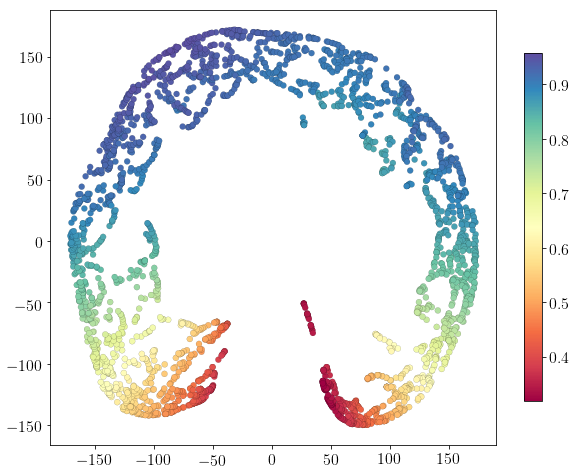

In [370]:
score_phate = coranking_quality(X, Y_phate, 'QNK', 1, 250)
rho_phate = geo_rho(X, Y_phate, GX = GX)
plot2D(Y_phate, label = rho_phate,figsize=(10, 8))

In [360]:
print(np.mean(rho_phate))
print(np.var(rho_phate))

0.747233007448874
0.038598584224803695


## 1.2 Isomap

In [481]:
from sklearn.manifold import Isomap
n_neighbors = 12
n_components = 2
t0 = time.time()
Y_iso = Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time.time()
print("Isomap: %.2g sec" % (t1 - t0))

Isomap: 4.1 sec


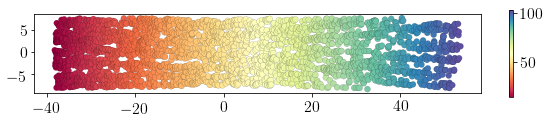

In [549]:
plot2D(Y_iso, label = color, figsize=(10, 2))
plt.axes().set_aspect(1.0)

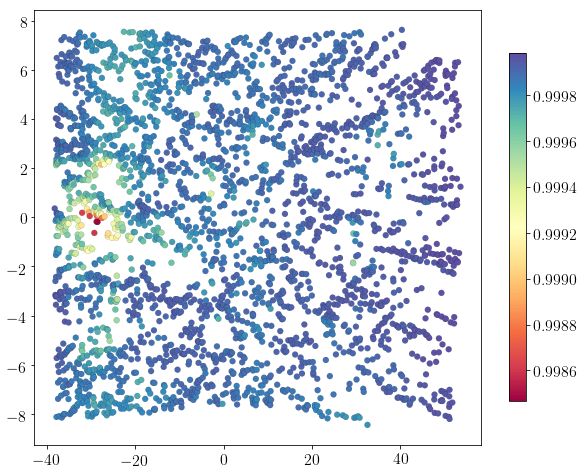

In [482]:
#GX = pairwise_distances(np.vstack((color, y)).T)
#GX = pairwise_distances(y.reshape((X.shape[0], 1)))
#Y_iso0 = Y_iso[:, 1].reshape((X.shape[0], 1))
rho_iso = geo_rho(X, Y_iso, GX = GX)
plot2D(Y_iso, label = rho_iso, figsize=(10, 8))

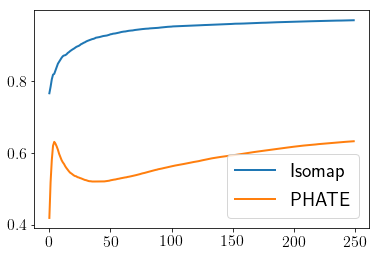

In [556]:
score_iso = coranking_quality(Xtruth, Y_iso, "QNK", 1, 250)

fig, ax = plt.subplots()
line1, = ax.plot(range(len(score_iso)), score_iso, 
                 linewidth=2,label='Isomap')
line1, = ax.plot(range(len(score_iso)), score_phate, 
                 linewidth=2,label='PHATE')
ax.legend(loc='lower right')
plt.show()

In [557]:
print(np.mean(rho_phate))
np.mean(rho_iso)

0.747233007448874


0.9998567747557896

In [ ]:
#line1.set_dashes(dashes)
# line2, = ax.plot(x, -1 * np.sin(x), dashes=[30, 5, 10, 5],
#                  label='Dashes set proactively')
# score = embedding_quality(X, Y_iso, method = 'lcmc')
# plt.plot(range(50), score)

## 1.3 Standard t-SNE

t-SNE embedding in 17.083530 sec


(-61.098236695839944,
 57.743595735146585,
 -60.07112275032068,
 71.53008423713709)

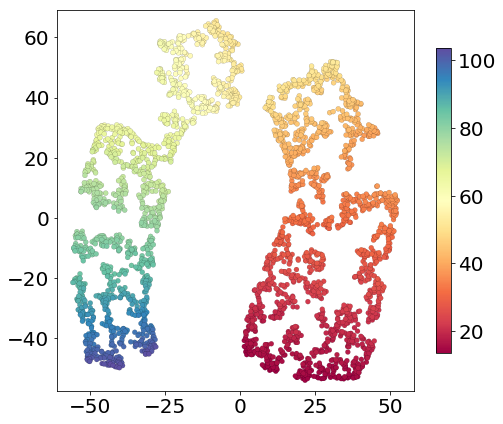

In [5]:
from sklearn.manifold import TSNE
start = time.time()
Y_tsne_perp30 = TSNE(n_components=2, perplexity=30).fit_transform(X)
end = time.time()
print('t-SNE embedding in %f sec' %(end-start))
plot2D(Y_tsne_perp30, label=color, s=25, figsize=(8,7))
plt.axis('equal')

t-SNE embedding in 51.416656 sec


(-18.483990613534033,
 16.719511930062353,
 -14.857532223739874,
 12.414146145859013)

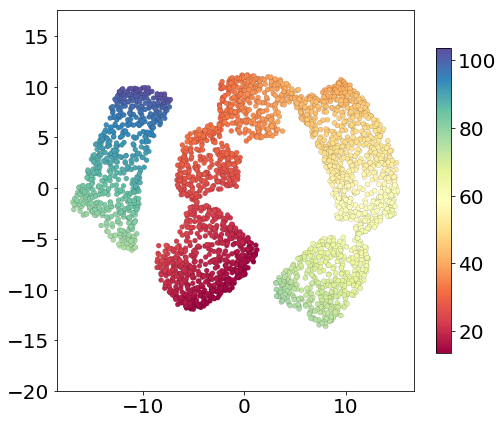

In [6]:
from sklearn.manifold import TSNE
start = time.time()
Y_tsne_perp300 = TSNE(n_components=2, perplexity=300).fit_transform(X)
end = time.time()
print('t-SNE embedding in %f sec' %(end-start))
plot2D(Y_tsne_perp300, label=color, s=25, figsize=(8,7))
plt.axis('equal')

## 1.4 Diffusion t-SNE

Making directory examples/swiss_roll/
Current directory /home/lanhuong/Projects/ManifoldLearning/DiffusionTSNE/examples/swiss_roll
data_path: data.dat
Using compiled binary file: /bin/diffusion_tsne
Diffusion t-SNE embedding in 79.915151 sec


(-37.47433184123354, 42.99044001491989, -14.332448148035084, 9.92772513046597)

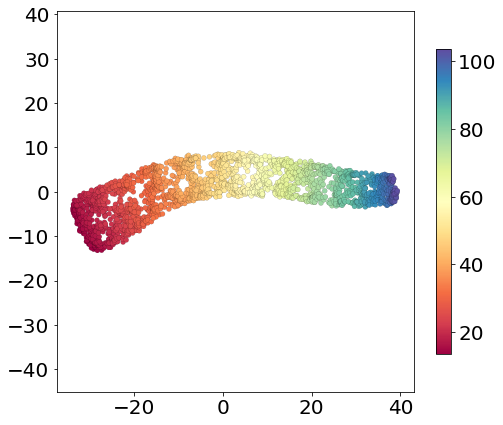

In [17]:
start = time.time()
Y_difftsne_p25t10 = diffusion_tsne(
    X, perplexity=25, time_steps=10,
    seed=12345, nthreads=nthreads,
    load_affinities="save", save_files=True, affinities_dir = "examples/SwissRoll/"
)
end = time.time()
print('Diffusion t-SNE embedding in %f sec' %(end-start))
plot2D(Y_difftsne_p25t10, label=color, s=25, figsize=(8,7))
plt.axis('equal')

Current directory /home/lanhuong/Projects/ManifoldLearning/DiffusionTSNE/examples/swiss_roll
data_path: data.dat
Using compiled binary file: /bin/diffusion_tsne
Diffusion t-SNE embedding in 88.067390 sec


(-11.918688423955235,
 13.295725401292716,
 -5.057309113561443,
 4.799581571581587)

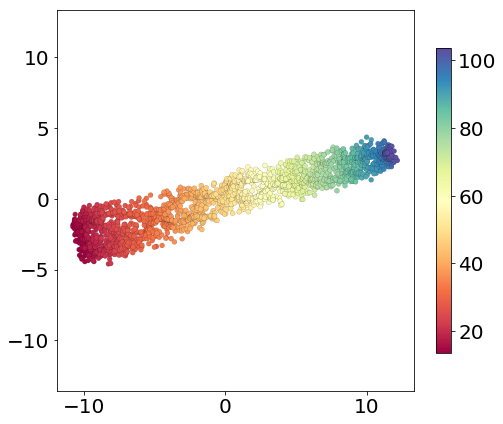

In [18]:
start = time.time()
start = time.time()
Y_difftsne_p25t10 = diffusion_tsne(
    X, perplexity=50, time_steps=30, seed=475, nthreads=nthreads,
    load_affinities="save", save_files=True, affinities_dir = "examples/SwissRoll/"
)
end = time.time()
print('Diffusion t-SNE embedding in %f sec' %(end-start))
plot2D(Y_difftsne_p25t10, label=color, s=25, figsize=(8,7))
plt.axis('equal')

## 1.5 Scaled Diffusion t-SNE

Current directory /home/lanhuong/Projects/ManifoldLearning/DiffusionTSNE/examples/SwissRoll
data_path: data.dat
Using compiled binary file: /bin/diffusion_tsne
Diffusion t-SNE embedding in 65.929047 sec


(-33.55701983884892, 25.489963058666973, -11.028752835658675, 9.92597353743269)

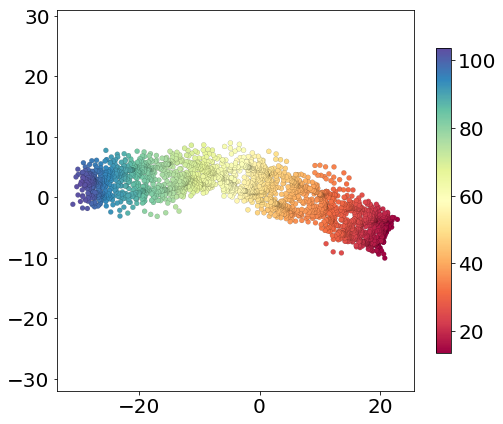

In [35]:
start = time.time()
Y_difftsne_scale = diffusion_tsne(
    X, perplexity=25, time_steps=30,
    seed=1, nthreads=nthreads, scale_probs = True,
     load_affinities="save", 
    save_files=True, affinities_dir = "examples/SwissRoll/"
)
end = time.time()
print('Diffusion t-SNE embedding in %f sec' %(end-start))
plot2D(Y_difftsne_scale, label=color, s=25, figsize=(8,7))
plt.axis('equal')

In [27]:
os.getcwd()

'/home/lanhuong/Projects/ManifoldLearning/DiffusionTSNE'

# 2. Performance evaluation

## 2.1 Standard t-SNE

In [151]:
np.log( [10, 25, 50, 100, 250, 500])

array([2.30258509, 3.21887582, 3.91202301, 4.60517019, 5.52146092,
       6.2146081 ])

In [343]:
def standard_tsne(X, perp, nthreads, seed):
    it_dir = 'examples/SwissRoll/standard_tsne/affinities_perp'+ \
        str(perp) + '_it' + str(seed) + "/"
    start = time.time()
    Y = diffusion_tsne(
        X, perplexity=perp, seed=seed, nthreads=nthreads, 
        load_affinities="save", save_files=True, affinities_dir = it_dir)
    end = time.time()
    res = {'embedding' : Y, 'time' : end - start, 'seed' : seed, 
           'perp' : perp, 'method' : 'standard_tsne'}
    return res

results = {}
ncopies = 5
perps  = [10, 25, 50, 100, 250, 300, 500]
NCORES = 40
pool = mp.Pool(processes = min(len(perps)*ncopies*nthreads, NCORES, mp.cpu_count()))
for perp in perps:
    print('Perplexity: %d' %(perp))
    for i in range(ncopies):
        seed = np.random.randint(1, 1e5, size = 1)[0]
        trial = 'perp' + str(perp) + '_it' + str(i)
        results[trial] = pool.apply_async(standard_tsne, args = (X, perp, nthreads, seed))
pool.close()
pool.join()
vanilla_tsne_res = {name : result.get() for name, result in results.items()}

filename = 'examples/SwissRoll/standard_tsne/embeddings.pkl'
with open(filename, 'wb') as handle:
    pickle.dump(vanilla_tsne_res, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [276]:
names

['$perp10', '$perp25', '$perp50', '$perp100', '$perp250']

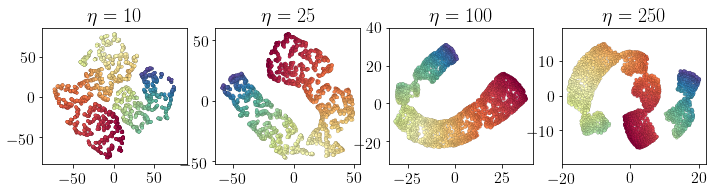

In [552]:
perps  = [10, 25, 50, 100, 250]
embds = [vanilla_tsne_res['perp' + str(perp) + '_it2']['embedding'] for perp in perps]
names = [r"$\eta = %d$" %perp for perp in perps]
plot_embdeddings(embds, color=color, 
                 name_lst=names, figsize=(15, 2.5), 
                 s = 10, edgecolor='black', linewidth=0.1, fontsize = 20)

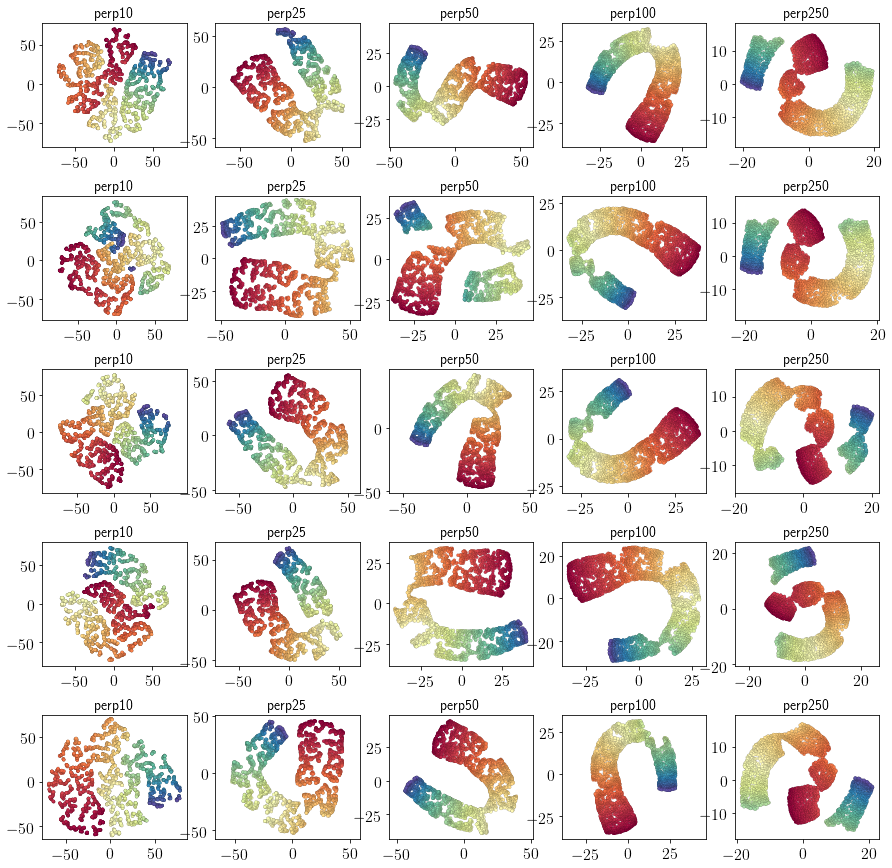

In [345]:
perps  = [10, 25, 50, 100, 250]
vanilla_tsne_embd, vanilla_tsne_time = get_res(
    vanilla_tsne_res, color, perps, figsize = (15, 15))
plt.subplots_adjust(hspace=0.4, wspace=0.2)

In [346]:
perps  = [10, 25, 50, 100, 250, 300, 500]
vanilla_tsne_spearman_mean = {}
vanilla_tsne_spearman_var = {}

keys = list(vanilla_tsne_embd.keys())
for perp in perps:
    cur_keys = [key for key in keys if 'perp' + str(perp) + '_' in key]
    pool = mp.Pool(processes = min(len(cur_keys), mp.cpu_count()))
    results = {}
    for key in cur_keys:
        Y = vanilla_tsne_embd[key]
        results[key] = pool.apply_async(geo_rho, args = (X, Y, GX))
    pool.close()
    pool.join()
    rho_mean_lst = [np.mean(res.get()) for name, res in results.items()]  # over data points
    rho_var_lst = [np.var(res.get()) for name, res in results.items()]
    vanilla_tsne_spearman_mean['perp' + str(perp)] = rho_mean_lst
    vanilla_tsne_spearman_var['perp' + str(perp)] = rho_var_lst

In [155]:
# import pickle
# filename = 'examples/SwissRoll/standard_tsne/swiss_roll_vanilla_tsne.pkl'
# outfile = open(filename,'wb')
# obj_dict = {'X': X, 'color':color, 'y': y,
#             'vanilla_tsne_res':vanilla_tsne_res, 
#             'vanilla_tsne_spearman_mean':vanilla_tsne_spearman_mean,
#             'vanilla_tsne_spearman_var':vanilla_tsne_spearman_var
#            }
# pickle.dump(obj_dict, outfile)
# outfile.close()

In [ ]:
import pickle
filename = 'examples/SwissRoll/standard_tsne/swiss_roll_vanilla_tsne.pkl'
infile = open(filename,'rb')
new_dict = pickle.load(infile) 
infile.close()
locals().update(new_dict)

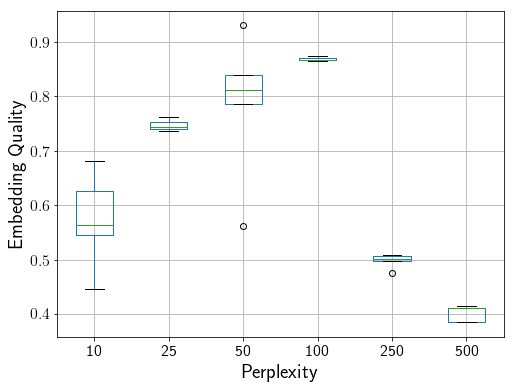

In [351]:
import pandas as pd
perps  = [10, 25, 50, 100, 250, 500]
df = pd.DataFrame(vanilla_tsne_spearman_mean, 
                  columns = ['perp' + str(perp) for perp in perps])
df.columns = [str(perp) for perp in perps]
plt.figure(figsize=(8, 6))
df.boxplot()
plt.xlabel("Perplexity")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 20})

In [157]:
print(df.mean())
print(np.sqrt(df.var()))

10     0.532278
25     0.753321
50     0.835363
100    0.871744
250    0.488518
500    0.406352
dtype: float64
10     0.138189
25     0.011535
50     0.033199
100    0.013099
250    0.027813
500    0.008022
dtype: float64


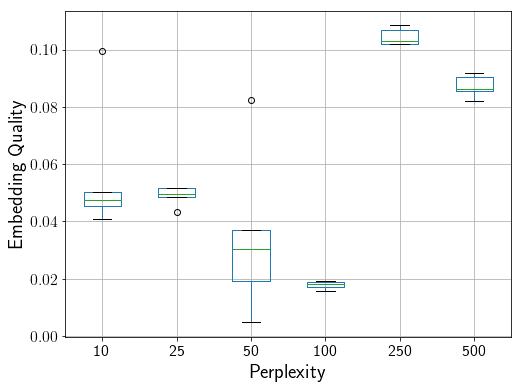

In [352]:
perps  = [10, 25, 50, 100, 250, 500]
dfvar = pd.DataFrame(vanilla_tsne_spearman_var, 
                  columns = ['perp' + str(perp) for perp in perps])
dfvar.columns = [str(perp) for perp in perps]
plt.figure(figsize=(8, 6))
dfvar.boxplot()
plt.xlabel("Perplexity")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 20})

In [376]:
vanilla_tsne_corank.keys()

dict_keys(['perp10', 'perp25', 'perp50', 'perp100', 'perp250', 'perp300', 'perp500'])

In [575]:
# Coranking matrix
perps  = [10, 25, 50, 100, 250, 300, 500]
vanilla_tsne_corank = {}   
keys = list(vanilla_tsne_embd.keys())
for perp in perps:
    cur_keys = [key for key in keys if 'perp' + str(perp) + '_' in key]
    pool = mp.Pool(processes = min(len(cur_keys), mp.cpu_count()))
    results = {}
    for key in cur_keys:
        Y = vanilla_tsne_embd[key]
        results[key] = pool.apply_async(coranking_quality, args = (Xtruth, Y, 'QNK', 1, 250))
    pool.close()
    pool.join()
    crank = { name: res.get() for name, res in results.items()}
    vanilla_tsne_corank['perp' + str(perp)] = crank

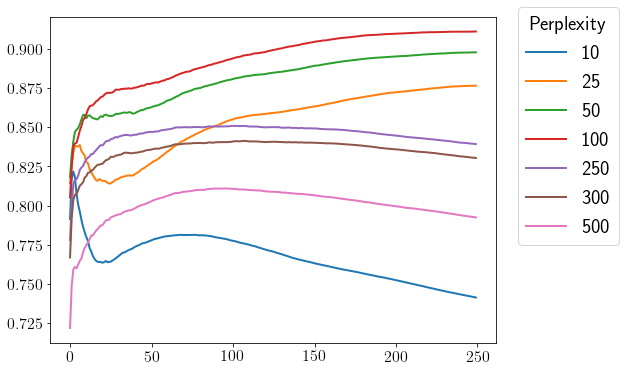

In [576]:
fig, ax = plt.subplots(figsize = (8, 6))
for perp in perps:
    pname = 'perp' + str(perp) 
    perp_corank = vanilla_tsne_corank[pname]
    perp_corank = [ val for k, val in perp_corank.items()]
    perp_corank = np.array(perp_corank)
    mean_perp_corank = np.mean(perp_corank, axis = 0).ravel()
    n = mean_perp_corank.shape[0]
    line, = ax.plot(range(n), mean_perp_corank, linewidth=2, label=str(perp))
ax.legend(loc=(250, 0), title='Perplexity', bbox_to_anchor= (1.05, 0.3))
plt.show()

In [577]:
import pickle
filename = 'examples/SwissRoll/standard_tsne/swiss_roll_vanilla_tsne.pkl'
outfile = open(filename,'wb')
obj_dict = {'X': X, 'color':color, 'y': y,
            'vanilla_tsne_res':vanilla_tsne_res, 
            'vanilla_tsne_spearman_mean':vanilla_tsne_spearman_mean,
            'vanilla_tsne_spearman_var':vanilla_tsne_spearman_var,
            'vanilla_tsne_corank':vanilla_tsne_corank
           }
pickle.dump(obj_dict, outfile)
outfile.close()

## 2.2. Diffusion t-SNE

In [164]:
def difftsne(X, perp, tstep, nthreads, seed):
    it_dir = 'examples/SwissRoll/diffusion_tsne/affinities_perp'+\
        str(perp) + '_tstep' + str(tstep) + '_it' + str(seed) + "/"
    start = time.time()
    Y = diffusion_tsne(
        X, seed=seed, time_steps = tstep, perplexity = perp,
        scale_probs = False, nthreads=nthreads, 
        load_affinities="save", save_files=True, affinities_dir = it_dir)
    end = time.time()
    res = {'embedding' : Y, 'perp' : perp, 'tstep': tstep, 
           'method' : 'diffusion_fitsne', 'seed' : seed,
           'time' : end - start}
    return res

ncopies = 5; NCORES = 40
perps  = [10, 20, 25, 30, 50]
tsteps  = [1, 5, 10, 20, 50, 100]
nComb = len(tsteps) * ncopies 
difftsne_res_dict = {}
for perp in perps:
    pool = mp.Pool(processes = min(nComb, int(NCORES/nthreads), int(mp.cpu_count()/nthreads)))
    results = {}
    for tstep in tsteps: 
        print('Perplexity: %d, t-step %d' %(perp, tstep))
        for i in range(ncopies):
            seed = np.random.randint(1, 1e5, size = 1)[0]
            trial = 'perp' + str(perp) + '_tstep' + str(tstep) +'_it' + str(i)
            try:
                results[trial] = pool.apply_async(
                    difftsne, args = (X, perp, tstep, nthreads, seed))
            except:
                results[trial] = {'embedding' : -1, 'time': -1}
    pool.close()
    pool.join()
    res = {name : result.get() for name, result in results.items()}
    difftsne_res_dict['perp' + str(perp)] = res
difftsne_res = difftsne_res_dict['perp' + str(perps[0])]
for i in range(1, len(perps)):
    difftsne_res.update(difftsne_res_dict['perp' + str(perps[i])])

Making directory ./DiffusionTSNE/results/SwissRoll/diffusion_tsne/affinities_perp10_tstep1_it858/
Making directory ./DiffusionTSNE/results/SwissRoll/diffusion_tsne/affinities_perp10_tstep1_it81725/
Making directory ./DiffusionTSNE/results/SwissRoll/diffusion_tsne/affinities_perp10_tstep1_it82002/
Making directory ./DiffusionTSNE/results/SwissRoll/diffusion_tsne/affinities_perp10_tstep1_it1765/
Making directory ./DiffusionTSNE/results/SwissRoll/diffusion_tsne/affinities_perp10_tstep5_it97538/
Making directory ./DiffusionTSNE/results/SwissRoll/diffusion_tsne/affinities_perp10_tstep5_it38830/
Making directory ./DiffusionTSNE/results/SwissRoll/diffusion_tsne/affinities_perp10_tstep1_it62109/
Making directory ./DiffusionTSNE/results/SwissRoll/diffusion_tsne/affinities_perp10_tstep5_it94307/
Making directory ./DiffusionTSNE/results/SwissRoll/diffusion_tsne/affinities_perp10_tstep5_it79142/
Making directory ./DiffusionTSNE/results/SwissRoll/diffusion_tsne/affinities_perp10_tstep5_it24452/
Per

Making directory ./DiffusionTSNE/results/SwissRoll/diffusion_tsne/affinities_perp25_tstep20_it25333/
Making directory ./DiffusionTSNE/results/SwissRoll/diffusion_tsne/affinities_perp25_tstep20_it47638/
Making directory ./DiffusionTSNE/results/SwissRoll/diffusion_tsne/affinities_perp25_tstep20_it67274/
Making directory ./DiffusionTSNE/results/SwissRoll/diffusion_tsne/affinities_perp25_tstep50_it52882/
Making directory ./DiffusionTSNE/results/SwissRoll/diffusion_tsne/affinities_perp25_tstep50_it30306/
Making directory ./DiffusionTSNE/results/SwissRoll/diffusion_tsne/affinities_perp25_tstep50_it12240/
Making directory ./DiffusionTSNE/results/SwissRoll/diffusion_tsne/affinities_perp25_tstep50_it82282/
Making directory ./DiffusionTSNE/results/SwissRoll/diffusion_tsne/affinities_perp25_tstep50_it36280/
Making directory ./DiffusionTSNE/results/SwissRoll/diffusion_tsne/affinities_perp25_tstep100_it96825/
Making directory ./DiffusionTSNE/results/SwissRoll/diffusion_tsne/affinities_perp25_tstep1

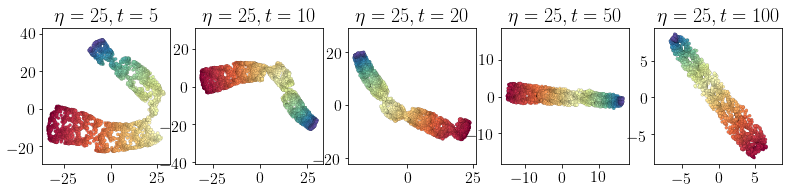

In [480]:
tsteps  = [5, 10, 20, 50, 100]
embds = [difftsne_res['perp25_tstep' + str(tstep) + '_it0']['embedding'] for tstep in tsteps]
names = [r"$\eta = 25, t = %d$" %tstep for tstep in tsteps]
plot_embdeddings(embds, color=color, 
                 name_lst=names, figsize=(16, 2.5), ncol = 6,
                 s = 10, edgecolor='black', linewidth=0.1, fontsize = 20)

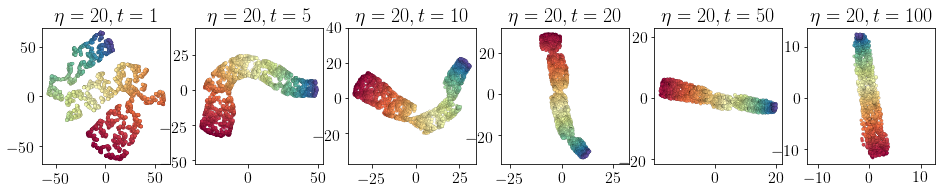

In [312]:
tsteps  = [1, 5, 10, 20, 50, 100]
embds = [difftsne_res['perp20_tstep' + str(tstep) + '_it0']['embedding'] for tstep in tsteps]
names = [r"$\eta = 20, t = %d$" %tstep for tstep in tsteps]
plot_embdeddings(embds, color=color, 
                 name_lst=names, figsize=(16, 2.5), ncol = 6,
                 s = 10, edgecolor='black', linewidth=0.1, fontsize = 20)

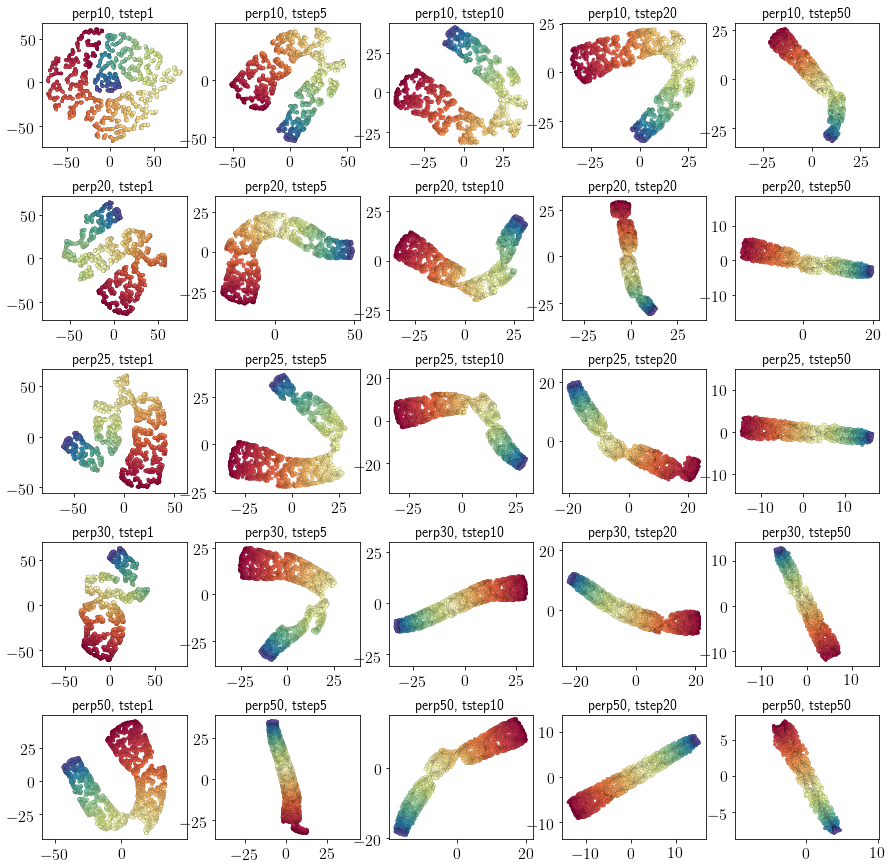

In [299]:
perps  = [10, 20, 25, 30, 50]
tsteps  = [1, 5, 10, 20, 50]
difftsne_embd, difftsne_time = get_res(
    difftsne_res, color, perps, 
    tsteps, figsize = (15, 15))
plt.subplots_adjust(hspace=0.4, wspace = 0.2)

In [170]:
# Performance
perps  = [10, 20, 25, 30, 50]
tsteps  = [1, 5, 10, 20, 50, 100]
keys = list(difftsne_embd.keys())
diff_tsne_spearman_mean = {}
diff_tsne_spearman_var = {}

keys = list(difftsne_embd.keys())
for perp in perps:
    for tstep in tsteps:
        comb = 'perp' + str(perp) + '_' + 'tstep' + str(tstep) + "_"
        cur_keys = [key for key in keys if comb in key]
        pool = mp.Pool(processes = min(len(cur_keys), mp.cpu_count()))
        results = {}
        for key in cur_keys:
            Y = difftsne_embd[key]
            results[key] = pool.apply_async(geo_rho, args = (X, Y, GX))
        pool.close()
        pool.join()
        rho_mean_lst = [np.mean(res.get()) for name, res in results.items()]  # over data points
        rho_var_lst = [np.var(res.get()) for name, res in results.items()]
        diff_tsne_spearman_mean[comb] = rho_mean_lst
        diff_tsne_spearman_var[comb] = rho_var_lst

In [564]:
# Coranking matrix
perps  = [10, 20, 25, 30, 50]
tsteps  = [1, 5, 10, 20, 50, 100]
diff_tsne_corank = {}   
keys = list(difftsne_embd.keys())
for perp in perps:
    for tstep in tsteps:
        comb = 'perp' + str(perp) + '_' + 'tstep' + str(tstep) + "_"
        cur_keys = [key for key in keys if comb in key]
        pool = mp.Pool(processes = min(len(cur_keys), mp.cpu_count()))
        results = {}
        for key in cur_keys:
            Y = difftsne_embd[key]
            results[key] = pool.apply_async(coranking_quality, args = (Xtruth, Y, 'QNK', 1, 250))
        pool.close()
        pool.join()
        crank = { name: res.get() for name, res in results.items()}
        diff_tsne_corank[comb] = crank

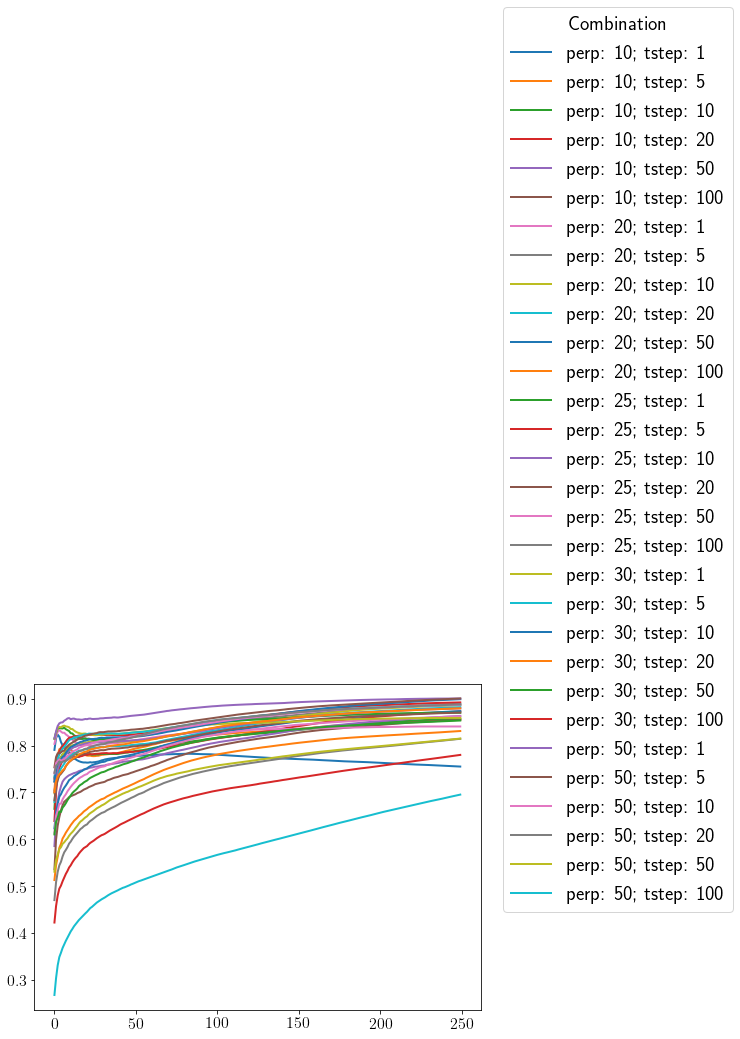

In [573]:
fig, ax = plt.subplots(figsize = (8, 6))
for perp in perps:
    for tstep in tsteps:
        comb = 'perp' + str(perp) + '_' + 'tstep' + str(tstep) + "_"
        comb_corank = diff_tsne_corank[comb]
        comb_corank = [ val for k, val in comb_corank.items()]
        comb_corank = np.array(comb_corank)
        mean_comb_corank = np.mean(comb_corank, axis = 0).ravel()
        n = mean_comb_corank.shape[0]
        line, = ax.plot(range(n), mean_comb_corank, linewidth=2, 
                        label= 'perp: ' + str(perp) + '; ' + 'tstep: ' + str(tstep))
ax.legend(loc=(250, 0), title='Combination', bbox_to_anchor= (1.05, 0.3))
plt.show()

In [574]:
import pickle
filename = 'examples/SwissRoll/diffusion_tsne/swiss_roll_diff_tsne.pkl'
outfile = open(filename,'wb')
obj_dict = {'X': X, 'color':color, 'y': y,
            'difftsne_res':difftsne_res, 
            'diff_tsne_spearman_mean':diff_tsne_spearman_mean,
            'diff_tsne_spearman_var':diff_tsne_spearman_var,
            'diff_tsne_corank':diff_tsne_corank
           }
pickle.dump(obj_dict, outfile)
outfile.close()

In [140]:
import pickle
filename = 'examples/SwissRoll/diffusion_tsne/swiss_roll_diff_tsne.pkl'
infile = open(filename,'rb')
new_dict = pickle.load(infile) 
infile.close()
locals().update(new_dict)

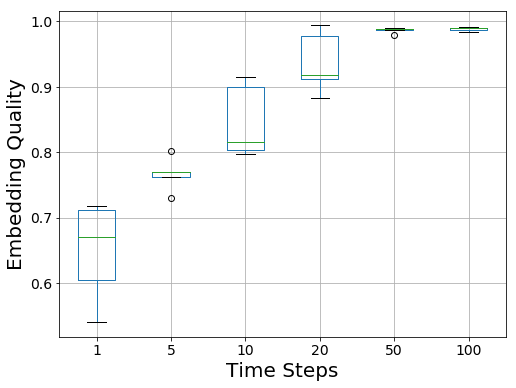

In [174]:
## import pandas as pd
keys = diff_tsne_spearman_mean.keys()
cols = [key for key in keys if 'perp10_' in key]
df = pd.DataFrame(diff_tsne_spearman_mean, columns = cols)
df.columns = tsteps
plt.figure(figsize=(8, 6))
df.boxplot()
plt.xlabel("Time Steps")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 20})

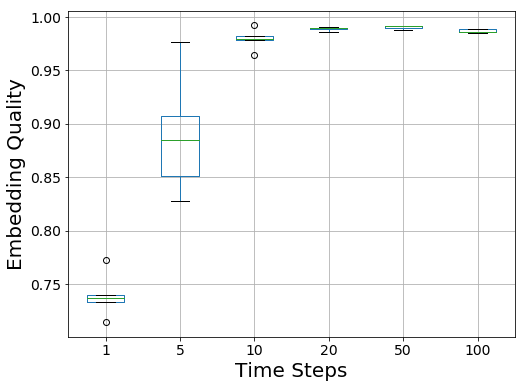

In [175]:
## import pandas as pd
keys = diff_tsne_spearman_mean.keys()
cols = [key for key in keys if 'perp20_' in key]
df = pd.DataFrame(diff_tsne_spearman_mean, columns = cols)
df.columns = tsteps
plt.figure(figsize=(8, 6))
df.boxplot()
plt.xlabel("Time Steps")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 20})

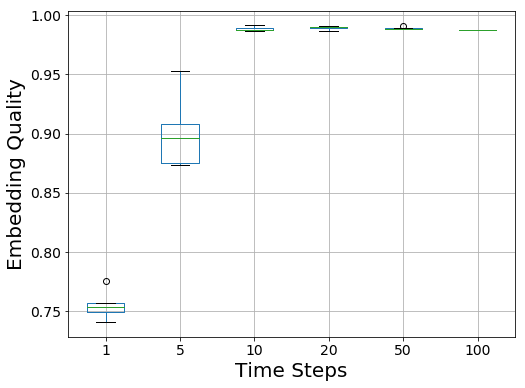

In [177]:
## import pandas as pd
keys = diff_tsne_spearman_mean.keys()
cols = [key for key in keys if 'perp25_' in key]
df = pd.DataFrame(diff_tsne_spearman_mean, columns = cols)
df.columns = tsteps
plt.figure(figsize=(8, 6))
df.boxplot()
plt.xlabel("Time Steps")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 16})

In [ ]:
print(df.mean())
print(np.sqrt(df.var()))

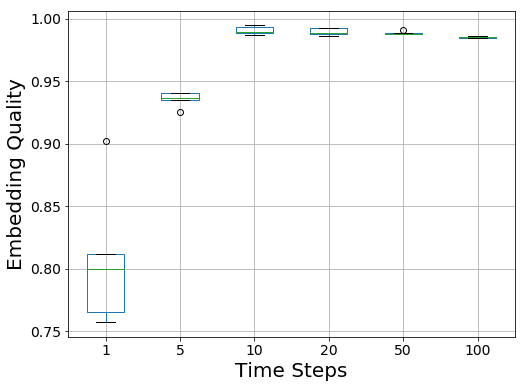

In [178]:
## import pandas as pd
keys = diff_tsne_spearman_mean.keys()
cols = [key for key in keys if 'perp30_' in key]
df = pd.DataFrame(diff_tsne_spearman_mean, columns = cols)
df.columns = tsteps
plt.figure(figsize=(8, 6))
df.boxplot()
plt.xlabel("Time Steps")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 16})

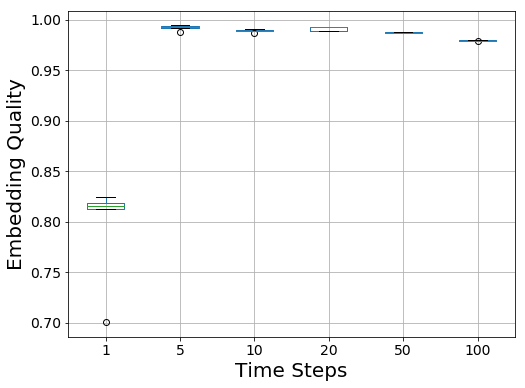

In [179]:
## import pandas as pd
keys = diff_tsne_spearman_mean.keys()
cols = [key for key in keys if 'perp50_' in key]
df = pd.DataFrame(diff_tsne_spearman_mean, columns = cols)
df.columns = tsteps
plt.figure(figsize=(8, 6))
df.boxplot()
plt.xlabel("Time Steps")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 16})

## 2.3 Scaled Diffusion t-SNE

In [192]:
def scaled_difftsne(X, perp, tstep, nthreads, seed):
    it_dir = 'examples/SwissRoll/scaled_diffusion_tsne/affinities_perp'+\
        str(perp) + '_tstep' + str(tstep) + '_it' + str(seed) + "/"
    start = time.time()
    Y = diffusion_tsne(
        X, seed=seed, time_steps = tstep, perplexity = perp,
        scale_probs = True, nthreads=nthreads, 
        load_affinities="save", save_files=True, affinities_dir = it_dir)
    end = time.time()
    res = {'embedding' : Y, 'perp' : perp, 'tstep': tstep, 
           'method' : 'diffusion_fitsne', 'seed' : seed,
           'time' : end - start}
    return res

ncopies = 5; NCORES = 40
perps  = [10, 20, 25, 30, 50]
tsteps  = [1, 5, 10, 20, 50, 100]
nComb = len(tsteps) * ncopies 
scaled_difftsne_res_dict = {}
for perp in perps:
    pool = mp.Pool(processes = min(nComb, int(NCORES/nthreads), int(mp.cpu_count()/nthreads)))
    results = {}
    for tstep in tsteps: 
        print('Perplexity: %d, t-step %d' %(perp, tstep))
        for i in range(ncopies):
            seed = np.random.randint(1, 1e5, size = 1)[0]
            trial = 'perp' + str(perp) + '_tstep' + str(tstep) +'_it' + str(i)
            try:
                results[trial] = pool.apply_async(
                    scaled_difftsne, args = (X, perp, tstep, nthreads, seed))
            except:
                results[trial] = {'embedding' : -1, 'time': -1}
    pool.close()
    pool.join()
    res = {name : result.get() for name, result in results.items()}
    scaled_difftsne_res_dict['perp' + str(perp)] = res
scaled_difftsne_res = scaled_difftsne_res_dict['perp' + str(perps[0])]
for i in range(1, len(perps)):
    scaled_difftsne_res.update(scaled_difftsne_res_dict['perp' + str(perps[i])])

Making directory examples/SwissRoll/scaled_diffusion_tsne/affinities_perp10_tstep1_it86132/
Making directory examples/SwissRoll/scaled_diffusion_tsne/affinities_perp10_tstep1_it1215/
Making directory examples/SwissRoll/scaled_diffusion_tsne/affinities_perp10_tstep1_it93622/
Making directory examples/SwissRoll/scaled_diffusion_tsne/affinities_perp10_tstep5_it85691/
Making directory examples/SwissRoll/scaled_diffusion_tsne/affinities_perp10_tstep1_it45371/
Making directory examples/SwissRoll/scaled_diffusion_tsne/affinities_perp10_tstep1_it24179/
Making directory examples/SwissRoll/scaled_diffusion_tsne/affinities_perp10_tstep5_it35392/
Making directory examples/SwissRoll/scaled_diffusion_tsne/affinities_perp10_tstep5_it70315/
Making directory examples/SwissRoll/scaled_diffusion_tsne/affinities_perp10_tstep5_it24478/
Making directory examples/SwissRoll/scaled_diffusion_tsne/affinities_perp10_tstep5_it63355/
Perplexity: 10, t-step 1
Perplexity: 10, t-step 5
Perplexity: 10, t-step 10
Perpl

Making directory examples/SwissRoll/scaled_diffusion_tsne/affinities_perp25_tstep50_it90800/
Making directory examples/SwissRoll/scaled_diffusion_tsne/affinities_perp25_tstep100_it70465/
Making directory examples/SwissRoll/scaled_diffusion_tsne/affinities_perp25_tstep100_it56678/
Making directory examples/SwissRoll/scaled_diffusion_tsne/affinities_perp25_tstep100_it53471/
Making directory examples/SwissRoll/scaled_diffusion_tsne/affinities_perp25_tstep100_it67964/
Making directory examples/SwissRoll/scaled_diffusion_tsne/affinities_perp25_tstep100_it49970/
Making directory examples/SwissRoll/scaled_diffusion_tsne/affinities_perp30_tstep1_it49481/
Making directory examples/SwissRoll/scaled_diffusion_tsne/affinities_perp30_tstep1_it10567/
Making directory examples/SwissRoll/scaled_diffusion_tsne/affinities_perp30_tstep1_it96046/
Making directory examples/SwissRoll/scaled_diffusion_tsne/affinities_perp30_tstep1_it20091/
Making directory examples/SwissRoll/scaled_diffusion_tsne/affinities_

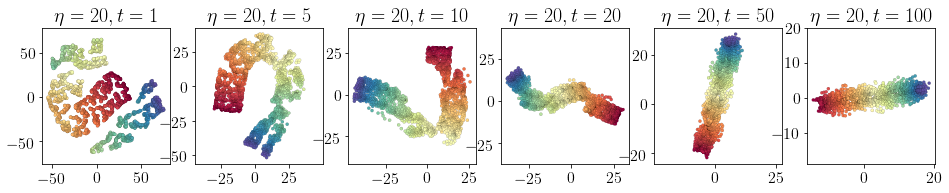

In [311]:
tsteps  = [1, 5, 10, 20, 50, 100]
embds = [scaled_difftsne_res['perp20_tstep' + str(tstep) + '_it0']['embedding'] 
         for tstep in tsteps]
names = [r"$\eta = 20, t = %d$" %tstep for tstep in tsteps]
plot_embdeddings(embds, color=color, 
                 name_lst=names, figsize=(16, 2.5), ncol = 6,
                 s = 10, edgecolor='black', linewidth=0.1, fontsize = 20)

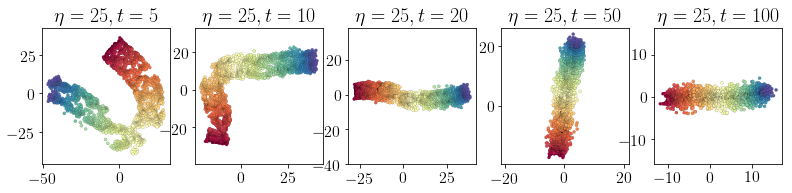

In [479]:
tsteps  = [5, 10, 20, 50, 100]
embds = [scaled_difftsne_res['perp25_tstep' + str(tstep) + '_it0']['embedding'] 
         for tstep in tsteps]
names = [r"$\eta = 25, t = %d$" %tstep for tstep in tsteps]
plot_embdeddings(embds, color=color, 
                 name_lst=names, figsize=(16, 2.5), ncol = 6,
                 s = 10, edgecolor='black', linewidth=0.1, fontsize = 20)

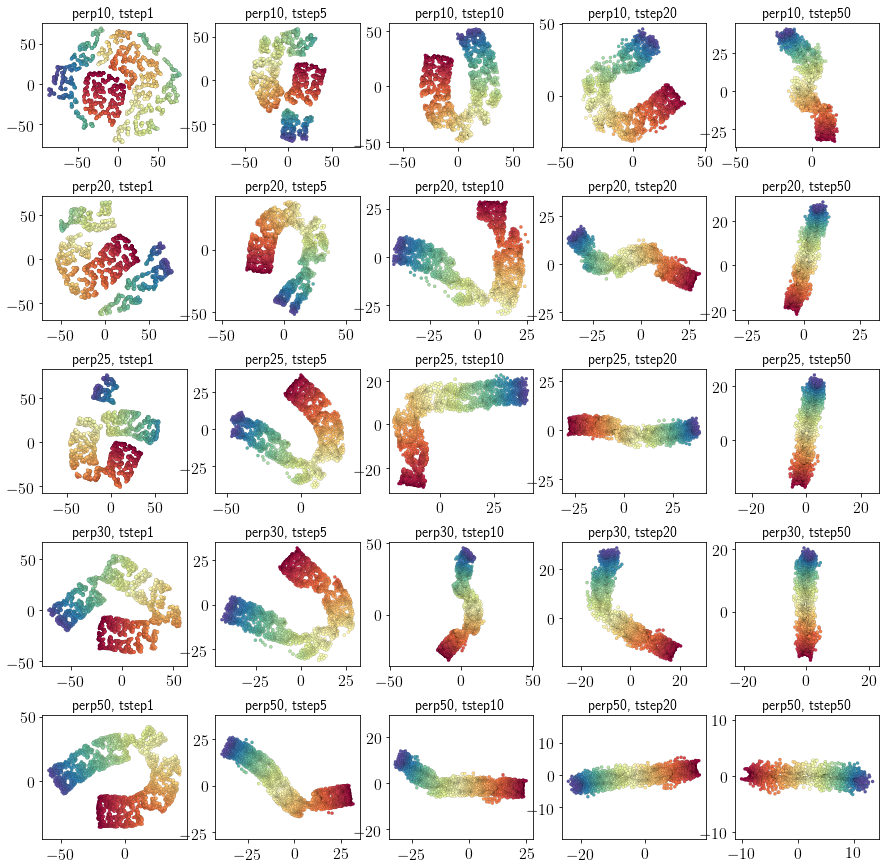

In [303]:
perps  = [10, 20, 25, 30, 50]
tsteps  = [1, 5, 10, 20, 50]q
scaled_difftsne_embd, scaled_difftsne_time = get_res(
    scaled_difftsne_res, color, perps, 
    tsteps, figsize = (15, 15))
plt.subplots_adjust(hspace=0.4, wspace = 0.2)

In [195]:
# Performance
perps  = [10, 20, 25, 30, 50]
tsteps  = [1, 5, 10, 20, 50, 100]
keys = list(scaled_difftsne_embd.keys())
scaled_diff_tsne_spearman_mean = {}
scaled_diff_tsne_spearman_var = {}

keys = list(scaled_difftsne_embd.keys())
for perp in perps:
    for tstep in tsteps:
        comb = 'perp' + str(perp) + '_' + 'tstep' + str(tstep) + "_"
        cur_keys = [key for key in keys if comb in key]
        pool = mp.Pool(processes = min(len(cur_keys), mp.cpu_count()))
        results = {}
        for key in cur_keys:
            Y = scaled_difftsne_embd[key]
            results[key] = pool.apply_async(geo_rho, args = (X, Y, GX))
        pool.close()
        pool.join()
        rho_mean_lst = [np.mean(res.get()) for name, res in results.items()]  # over data points
        rho_var_lst = [np.var(res.get()) for name, res in results.items()]
        scaled_diff_tsne_spearman_mean[comb] = rho_mean_lst
        scaled_diff_tsne_spearman_var[comb] = rho_var_lst

In [578]:
# Coranking matrix
perps  = [10, 20, 25, 30, 50]
tsteps  = [1, 5, 10, 20, 50, 100]
scaled_diff_tsne_corank = {}   
keys = list(scaled_difftsne_embd.keys())
for perp in perps:
    for tstep in tsteps:
        comb = 'perp' + str(perp) + '_' + 'tstep' + str(tstep) + "_"
        cur_keys = [key for key in keys if comb in key]
        pool = mp.Pool(processes = min(len(cur_keys), mp.cpu_count()))
        results = {}
        for key in cur_keys:
            Y = scaled_difftsne_embd[key]
            results[key] = pool.apply_async(coranking_quality, 
                                            args = (Xtruth, Y, 'QNK', 1, 250))
        pool.close()
        pool.join()
        crank = { name: res.get() for name, res in results.items()}
        scaled_diff_tsne_corank[comb] = crank

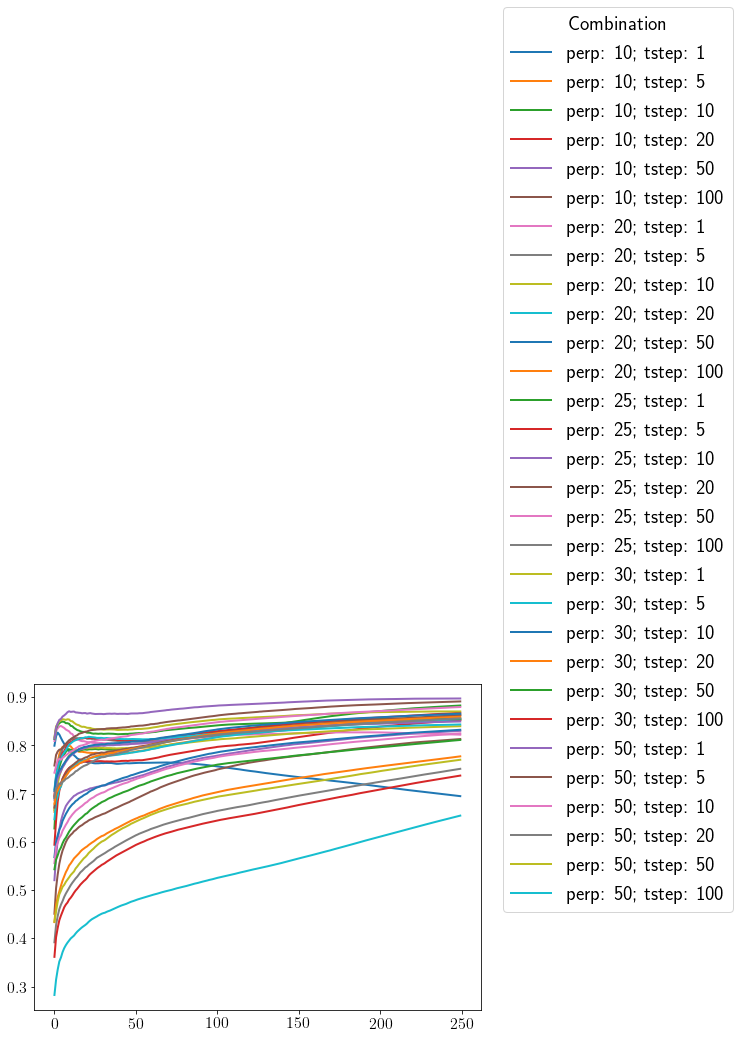

In [579]:
fig, ax = plt.subplots(figsize = (8, 6))
for perp in perps:
    for tstep in tsteps:
        comb = 'perp' + str(perp) + '_' + 'tstep' + str(tstep) + "_"
        comb_corank = scaled_diff_tsne_corank[comb]
        comb_corank = [ val for k, val in comb_corank.items()]
        comb_corank = np.array(comb_corank)
        mean_comb_corank = np.mean(comb_corank, axis = 0).ravel()
        n = mean_comb_corank.shape[0]
        line, = ax.plot(range(n), mean_comb_corank, linewidth=2, 
                        label= 'perp: ' + str(perp) + '; ' + 'tstep: ' + str(tstep))
ax.legend(loc=(250, 0), title='Combination', bbox_to_anchor= (1.05, 0.3))
plt.show()

In [580]:
import pickle
filename = 'examples/SwissRoll/scaled_diffusion_tsne/swiss_roll_scaled_diff_tsne.pkl'
outfile = open(filename,'wb')
obj_dict = {'X': X, 'color':color, 'y': y,
            'scaled_difftsne_res':scaled_difftsne_res, 
            'scaled_diff_tsne_spearman_mean':scaled_diff_tsne_spearman_mean,
            'scaled_diff_tsne_spearman_var':scaled_diff_tsne_spearman_var,
            'scaled_diff_tsne_corank':scaled_diff_tsne_corank
           }
pickle.dump(obj_dict, outfile)
outfile.close()

In [ ]:
import pickle
filename = 'examples/SwissRoll/scaled_diffusion_tsne/swiss_roll_scaled_diff_tsne.pkl'
infile = open(filename,'rb')
new_dict = pickle.load(infile) 
infile.close()
locals().update(new_dict)

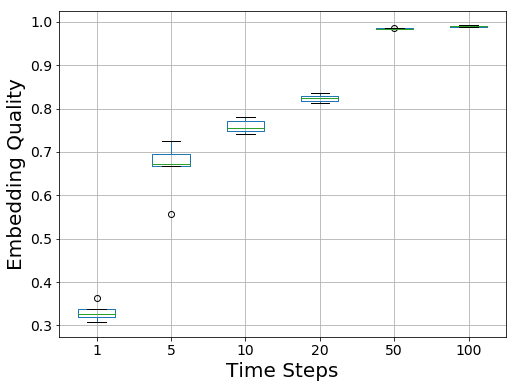

In [199]:
## import pandas as pd
keys = diff_tsne_spearman_mean.keys()
cols = [key for key in keys if 'perp10_' in key]
df = pd.DataFrame(scaled_diff_tsne_spearman_mean, columns = cols)
df.columns = tsteps
plt.figure(figsize=(8, 6))
df.boxplot()
plt.xlabel("Time Steps")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 16})

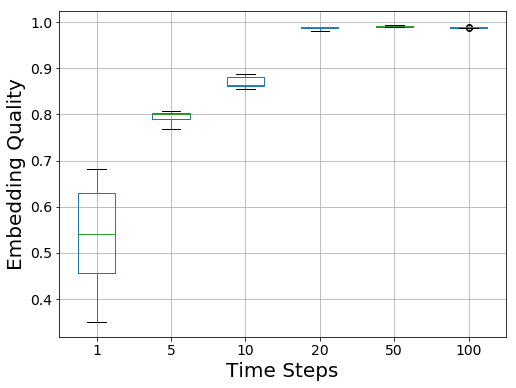

In [200]:
## import pandas as pd
keys = diff_tsne_spearman_mean.keys()
cols = [key for key in keys if 'perp20_' in key]
df = pd.DataFrame(scaled_diff_tsne_spearman_mean, columns = cols)
df.columns = tsteps
plt.figure(figsize=(8, 6))
df.boxplot()
plt.xlabel("Time Steps")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 16})

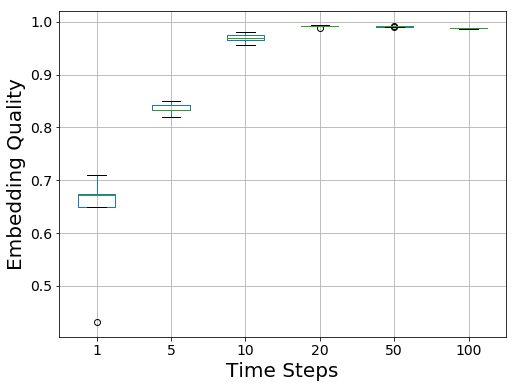

In [201]:
## import pandas as pd
keys = diff_tsne_spearman_mean.keys()
cols = [key for key in keys if 'perp25_' in key]
df = pd.DataFrame(scaled_diff_tsne_spearman_mean, columns = cols)
df.columns = tsteps
plt.figure(figsize=(8, 6))
df.boxplot()
plt.xlabel("Time Steps")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 16})

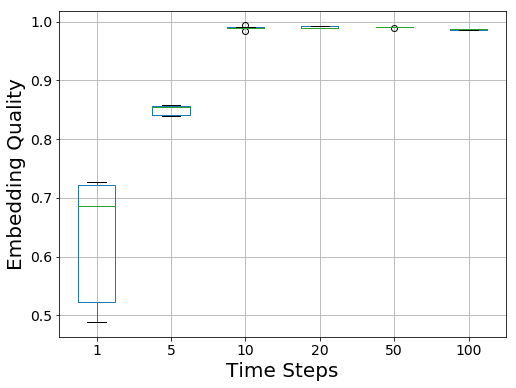

In [202]:
## import pandas as pd
keys = diff_tsne_spearman_mean.keys()
cols = [key for key in keys if 'perp30_' in key]
df = pd.DataFrame(scaled_diff_tsne_spearman_mean, columns = cols)
df.columns = tsteps
plt.figure(figsize=(8, 6))
df.boxplot()
plt.xlabel("Time Steps")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 16})

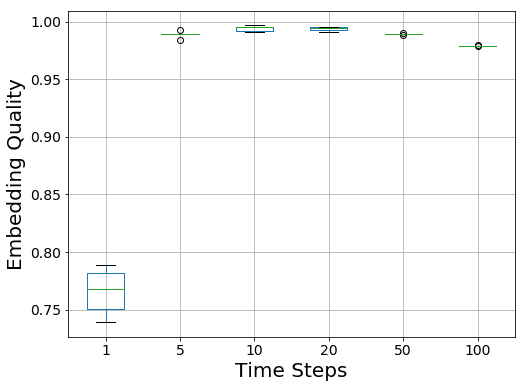

In [203]:
## import pandas as pd
keys = diff_tsne_spearman_mean.keys()
cols = [key for key in keys if 'perp50_' in key]
df = pd.DataFrame(scaled_diff_tsne_spearman_mean, columns = cols)
df.columns = tsteps
plt.figure(figsize=(8, 6))
df.boxplot()
plt.xlabel("Time Steps")
plt.ylabel("Embedding Quality")
plt.rcParams.update({'font.size': 16})

## 2.4 UMAP

In [228]:
import umap
# in our implementation of FIt-SNE we use entropy = np.log(perplexity) whereas in
# umap one has entropy = np.log2(n_neigh) so we need to adjust:
# np.log(100) = np.log2(n_neigh) ==> n_neigh = 2**np.log(100)
# n_neigh [10-15] ==> perplexity [30-50]

def run_umap(X, nthreads, seed):
    start = time.time()
    Y = umap.UMAP(random_state = seed, transform_seed = seed).fit_transform(X)
    end = time.time()
    res = {'embedding' : Y, 'method' : 'umap', 'seed' : seed,
           'time' : end - start}
    return res

ncopies = 5
pool = mp.Pool(processes = min(ncopies, int(NCORES/nthreads), int(mp.cpu_count()/nthreads)))
results = {}
for i in range(ncopies):
    seed = np.random.randint(1, time.time(), size = 1)[0]
    trial = 'it' + str(i)
    try:
        results[trial] = pool.apply_async(
            run_umap, args = (X, nthreads, seed))
    except:
        results[trial] = {'embedding' : -1, 'time': -1}
pool.close()
pool.join()
umap_res = {name : result.get() for name, result in results.items()}

/home/lanhuong/.local/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


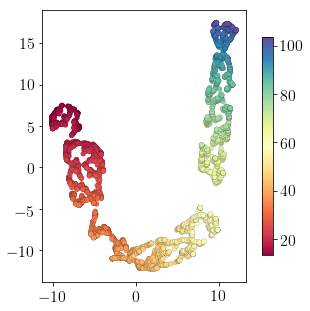

In [539]:
plot2D(umap_embd_lst[0], label=color, s=25, figsize=(6, 5))
plt.axes().set_aspect(1.0)

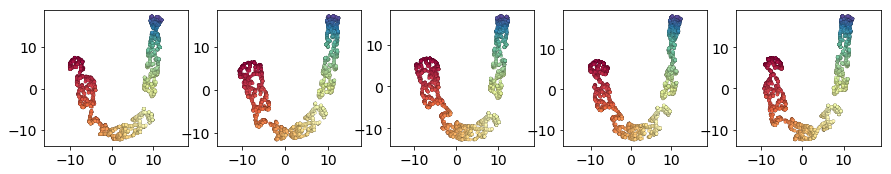

In [260]:
umap_embd_lst = [umap_res[key]['embedding'] for key in umap_res]
plot_embdeddings(umap_embd_lst, color, figsize=(15, 2.5), 
                s = 10, edgecolor='black', linewidth=0.1)

In [559]:
# Coranking matrix
umap_corank = {}
pool = mp.Pool(processes = min(len(cur_keys), mp.cpu_count()))
for key in umap_res.keys():
    Y = umap_res[key]['embedding']
    umap_corank[key] = pool.apply_async(coranking_quality, args = (Xtruth, Y, 'QNK', 1, 250))
pool.close()
pool.join()
umap_corank = { name: res.get() for name, res in umap_corank.items()}

In [560]:
# Coranking matrix
pool = mp.Pool(processes = min(len(cur_keys), mp.cpu_count()))
results= {}
for key in umap_res.keys():
    Y = umap_res[key]['embedding']
    results[key] = pool.apply_async(geo_rho, args = (X, Y, GX))
pool.close()
pool.join()

umap_spearman_mean = [np.mean(res.get()) for name, res in results.items()] 
umap_spearman_var = [np.var(res.get()) for name, res in results.items()] 

In [561]:
print("Mean and std of the average spearman rank correlation" + \
      " for UMAP is: %f +/- %f"
      %(np.mean(umap_spearman_mean),  np.std(umap_spearman_mean)))

Mean and std of the average spearman rank correlation for UMAP is: 0.878678 +/- 0.016063


In [562]:
umap_corank_df = pd.DataFrame(umap_corank)
umap_corank_df['mean'] = umap_corank_df.mean(axis = 1) 
umap_corank_df['sd'] = umap_corank_df.std(axis = 1) 
umap_corank_df.head()

it0       it1       it2       it3       it4      mean        sd
0  0.516839  0.548516  0.536179  0.531511  0.537513  0.534111  0.010280
1  0.612704  0.647883  0.641214  0.635879  0.628376  0.633211  0.012086
2  0.664888  0.684562  0.688896  0.676781  0.683339  0.679693  0.008359
3  0.698983  0.714738  0.719573  0.705985  0.713488  0.710554  0.007242
4  0.713505  0.726442  0.730443  0.721507  0.722441  0.722868  0.005655

<ErrorbarContainer object of 3 artists>

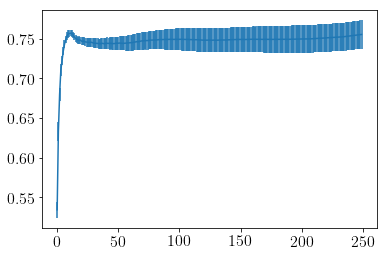

In [563]:
plt.errorbar(umap_corank_df.index, umap_corank_df['mean'], yerr=umap_corank_df['sd'])


# Plot Results

In [383]:
diff_tsne_corank['perp20_tstep1_'].keys()

dict_keys(['perp20_tstep1_it0', 'perp20_tstep1_it1', 'perp20_tstep1_it2', 'perp20_tstep1_it3', 'perp20_tstep1_it4'])

In [611]:
corank_df = pd.DataFrame(
    {
        'PCA':score_pca,
        'PHATE':score_phate,
        'ISOMAP':score_iso,
        'UMAP_mean': umap_corank_df['mean'],
        'UMAP_sd':umap_corank_df['sd'],
    }
)
chosen_perp = [25, 50, 100, 250]
chosen_tstep = [5, 10, 20, 50]

In [612]:
for perp in chosen_perp:
    if perp == 20:
        df = pd.DataFrame(diff_tsne_corank['perp20_tstep1_'])
    else:
        df = pd.DataFrame(vanilla_tsne_corank['perp'+str(perp)])
    corank_df['tSNE_perp' + str(perp) + '_mean']  = df.mean(axis = 1) 
    corank_df['tSNE_perp' + str(perp) + '_sd']  = df.std(axis = 1) 

In [613]:
for tstep in chosen_tstep:
    df = pd.DataFrame(diff_tsne_corank['perp25_tstep' + str(tstep) + "_"])
    corank_df['diff_tsne_corank' + str(tstep) + '_mean']  = df.mean(axis = 1) 
    corank_df['diff_tsne_corank' + str(tstep) + '_sd']  = df.std(axis = 1) 
    df = pd.DataFrame(scaled_diff_tsne_corank['perp25_tstep' + str(tstep) + "_"])
    corank_df['scaled_diff_tsne_corank' + str(tstep) + '_mean']  = df.mean(axis = 1) 
    corank_df['scaled_diff_tsne_corank' + str(tstep) + '_sd']  = df.std(axis = 1) 
corank_df0 = corank_df

In [584]:
corank_df.head()

PCA     PHATE    ISOMAP  UMAP_mean   UMAP_sd  tSNE_perp25_mean  \
0  0.091030  0.419140  0.765922   0.534111  0.010280          0.814271   
1  0.109537  0.518339  0.783928   0.633211  0.012086          0.826375   
2  0.119929  0.580416  0.804713   0.679693  0.008359          0.833722   
3  0.127459  0.619873  0.817689   0.710554  0.007242          0.837929   
4  0.132444  0.630744  0.819940   0.722868  0.005655          0.837866   

   tSNE_perp25_sd  tSNE_perp50_mean  tSNE_perp50_sd  tSNE_perp100_mean  \
0        0.001000          0.818139        0.004202           0.805268   
1        0.001832          0.832377        0.003332           0.824108   
2        0.001613          0.840814        0.002814           0.837479   
3        0.001073          0.847082        0.002653           0.839613   
4        0.000836          0.848349        0.002433           0.840093   

               ...               scaled_diff_tsne_corank10_mean  \
0              ...                                     0.687096   
1              ...                                     0.717573   
2              ...                                     0.731177   
3              ...                                     0.740063   
4              ...                                     0.746542   

   scaled_diff_tsne_corank10_sd  diff_tsne_corank20_mean  \
0                      0.010432                 0.683294   
1                      0.009950                 0.713304   
2                      0.008028                 0.726642   
3                      0.009188                 0.736212   
4                      0.009619                 0.739820   

   diff_tsne_corank20_sd  scaled_diff_tsne_corank20_mean  \
0               0.011910                        0.670890   
1               0.008810                        0.696932   
2               0.009015                        0.708103   
3               0.006648                        0.718006   
4               0.007597                        0.721587   

   scaled_diff_tsne_corank20_sd  diff_tsne_corank50_mean  \
0                      0.010615                 0.614205   
1                      0.008260                 0.650517   
2                      0.007383                 0.661754   
3                      0.007945                 0.676259   
4                      0.007591                 0.675892   

   diff_tsne_corank50_sd  scaled_diff_tsne_corank50_mean  \
0               0.009992                        0.555852   
1               0.006870                        0.588830   
2               0.008035                        0.598422   
3               0.009119                        0.607853   
4               0.007413                        0.613431   

   scaled_diff_tsne_corank50_sd  
0                      0.003853  
1                      0.004721  
2                      0.003866  
3                      0.004924  
4                      0.004533  

[5 rows x 29 columns]

In [622]:
#corank_df = corank_df.iloc[0:50, :]
corank_df =corank_df0

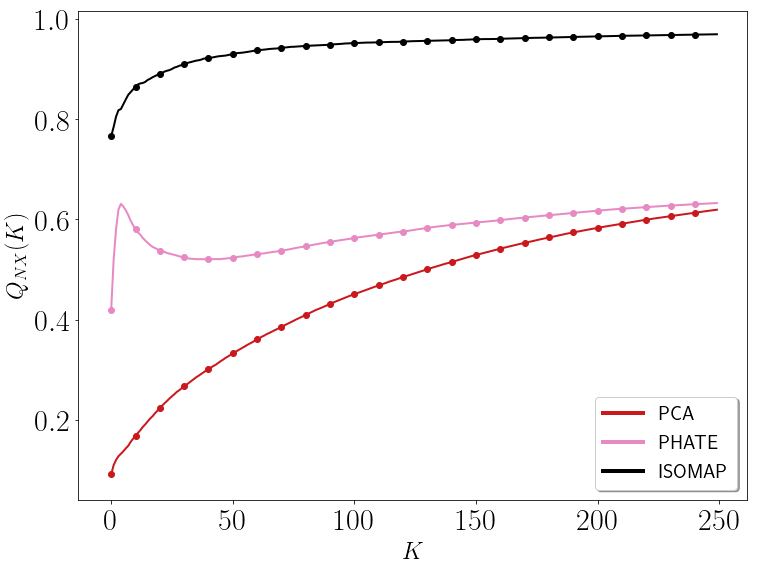

In [625]:
df2plot = corank_df.iloc[::10, :]
tsne_cols = ["#A1D99B" , "#41AB5D" ,"#238B45" ,"#00441B"]
difftsne_colors = ["#FDAE6B", "#F16913", "#D94801", "#7F2704" ]
scaled_diff_tsne_colors = ["#BCBDDC",  "#807DBA" ,"#54278F", "#3F007D"]
mpl.rcParams['xtick.labelsize']  = 30
mpl.rcParams['ytick.labelsize']  = 30


plt.figure(figsize = (12, 9))

plt.scatter(df2plot.index, df2plot['PCA'], marker = 'o', label ='', c = "#CB181D")
plt.scatter(df2plot.index, df2plot['PHATE'], marker='o', label = '', c="#E78AC3" )
plt.plot(corank_df.index, corank_df['PCA'], label ='PCA', c = "#CB181D",  linewidth = 2)
plt.plot(corank_df.index, corank_df['PHATE'],  label = 'PHATE', c="#E78AC3",  linewidth = 2)

plt.scatter(df2plot.index, df2plot['ISOMAP'], marker='o', label = '', c="black" )
plt.plot(corank_df.index, corank_df['ISOMAP'],  label = 'ISOMAP', c="black",  linewidth = 2 )

# plt.plot(corank_df.index, corank_df['UMAP_mean'], 
#          linewidth = 2, label ='UMAP', c =  "#6BAED6")
# plt.errorbar(df2plot.index, df2plot['UMAP_mean'], yerr=df2plot['UMAP_sd'], 
#              linewidth =0, elinewidth=2, label = '', c =  "#6BAED6", capsize=3)
# for i, perp in enumerate(chosen_perp):
#     plt.plot(corank_df.index, corank_df['tSNE_perp'+ str(perp) + '_mean'],
#              label =r'tSNE: $\eta=%d$' %perp, c = tsne_cols[i], linewidth=2)
#     plt.errorbar(df2plot.index, df2plot['tSNE_perp'+ str(perp) + '_mean'], 
#                  yerr=df2plot['tSNE_perp'+ str(perp) +'_sd'], capsize=3,
#                  linewidth =0, elinewidth=2, label = '', c = tsne_cols[i])
# for i, tstep in enumerate(chosen_tstep):
#     plt.plot(corank_df.index, corank_df['diff_tsne_corank'+ str(tstep) + '_mean'],
#              label =r'Diffusion tSNE: $\eta=25, t=%d$' %tstep, c = difftsne_colors[i],
#             linewidth=2)
#     plt.errorbar(df2plot.index, df2plot['diff_tsne_corank'+ str(tstep) + '_mean'], 
#                  yerr=df2plot['diff_tsne_corank'+ str(tstep) +'_sd'], capsize=3,
#                  linewidth =0, elinewidth=2, label = '', c = difftsne_colors[i])
    
# for i, tstep in enumerate(chosen_tstep):
#     plt.plot(corank_df.index, corank_df['scaled_diff_tsne_corank'+ str(tstep) + '_mean'],
#              label =r'Scaled diffusion tSNE: $\eta=25, t=%d$' %tstep, 
#              c = scaled_diff_tsne_colors[i], linewidth=2)
#     plt.errorbar(df2plot.index, df2plot['scaled_diff_tsne_corank'+ str(tstep) + '_mean'], 
#                  yerr=df2plot['scaled_diff_tsne_corank'+ str(tstep) +'_sd'], capsize=3,
#                  linewidth =0, elinewidth=2, label = '', c = scaled_diff_tsne_colors[i])

leg = plt.legend(
    fontsize=20, markerscale=1, 
    #loc='upper center', bbox_to_anchor=(1.3, 1.0), 
    shadow=True, ncol=1)

for line in leg.get_lines():
    line.set_linewidth(4.0)

plt.xlabel(r"$K$", fontsize=24)
plt.ylabel(r"$Q_{NX}(K)$", fontsize=24)

mpl.rcParams['xtick.labelsize']  = 16
mpl.rcParams['ytick.labelsize']  = 16

# Spearman Correlations

In [357]:
for perp in [10, 20, 25, 50, 100, 250, 300, 500]:
    if perp == 20:
        rho = diff_tsne_spearman_mean['perp20_tstep1_']
    else:
        rho = vanilla_tsne_spearman_mean['perp'+ str(perp)]
    print("Mean and std of the average spearman rank correlation" + \
          " for vanilla t-SNE at perp %d is: %.3f \; (%.4f)"
          %(perp, np.mean(rho),  np.std(rho)))

Mean and std of the average spearman rank correlation for vanilla t-SNE at perp 10 is: 0.573 \; (0.0794)
Mean and std of the average spearman rank correlation for vanilla t-SNE at perp 20 is: 0.739 \; (0.0189)
Mean and std of the average spearman rank correlation for vanilla t-SNE at perp 25 is: 0.747 \; (0.0095)
Mean and std of the average spearman rank correlation for vanilla t-SNE at perp 50 is: 0.786 \; (0.1222)
Mean and std of the average spearman rank correlation for vanilla t-SNE at perp 100 is: 0.868 \; (0.0036)
Mean and std of the average spearman rank correlation for vanilla t-SNE at perp 250 is: 0.498 \; (0.0121)
Mean and std of the average spearman rank correlation for vanilla t-SNE at perp 300 is: 0.459 \; (0.0152)
Mean and std of the average spearman rank correlation for vanilla t-SNE at perp 500 is: 0.403 \; (0.0134)


In [326]:
perp = 10
for tstep in tsteps:
    rho = diff_tsne_spearman_mean['perp'+ str(perp) + "_tstep" + str(tstep) + "_"]
    print("Mean and std of the avg. spearman rank correlation" + \
          " for Diffusion t-SNE at perp %d and t-step %dis: %.3f (%.4f)"
          %(perp, tstep, np.mean(rho),  np.std(rho)))

Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 1is: 0.649 (0.0674)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 5is: 0.767 (0.0229)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 10is: 0.847 (0.0502)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 20is: 0.937 (0.0419)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 50is: 0.987 (0.0035)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 100is: 0.989 (0.0025)


In [327]:
perp = 20
for tstep in tsteps:
    rho = diff_tsne_spearman_mean['perp'+ str(perp) + "_tstep" + str(tstep) + "_"]
    print("Mean and std of the avg. spearman rank correlation" + \
          " for Diffusion t-SNE at perp %d and t-step %dis: %.3f \; (%.4f)"
          %(perp, tstep, np.mean(rho),  np.std(rho)))

Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 1is: 0.739 \; (0.0189)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 5is: 0.890 \; (0.0515)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 10is: 0.979 \; (0.0087)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 20is: 0.989 \; (0.0015)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 50is: 0.991 \; (0.0016)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 100is: 0.987 \; (0.0015)


In [551]:
perp = 25
for tstep in tsteps:
    rho = diff_tsne_spearman_mean['perp'+ str(perp) + "_tstep" + str(tstep) + "_"]
    print("Mean and std of the avg. spearman rank correlation" + \
          " for Diffusion t-SNE at perp %d and t-step %dis: %.4f\; (%.4f)"
          %(perp, tstep, np.mean(rho),  np.std(rho)))

Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 25 and t-step 5is: 0.9012\; (0.0288)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 25 and t-step 10is: 0.9886\; (0.0015)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 25 and t-step 20is: 0.9892\; (0.0013)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 25 and t-step 50is: 0.9888\; (0.0013)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 25 and t-step 100is: 0.9873\; (0.0002)


In [331]:
perp = 30
for tstep in tsteps:
    rho = diff_tsne_spearman_mean['perp'+ str(perp) + "_tstep" + str(tstep) + "_"]
    print("Mean and std of the avg. spearman rank correlation" + \
          " for Diffusion t-SNE at perp %d and t-step %dis: %.3f \; (%.4f)"
          %(perp, tstep, np.mean(rho),  np.std(rho)))

Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 1is: 0.807 \; (0.0516)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 5is: 0.936 \; (0.0056)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 10is: 0.991 \; (0.0029)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 20is: 0.990 \; (0.0027)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 50is: 0.988 \; (0.0012)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 100is: 0.985 \; (0.0007)


In [332]:
perp = 50
for tstep in tsteps:
    rho = diff_tsne_spearman_mean['perp'+ str(perp) + "_tstep" + str(tstep) + "_"]
    print("Mean and std of the avg. spearman rank correlation" + \
          " for Diffusion t-SNE at perp %d and t-step %dis: %.3f \; (%.4f)"
          %(perp, tstep, np.mean(rho),  np.std(rho)))

Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 1is: 0.794 \; (0.0469)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 5is: 0.992 \; (0.0023)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 10is: 0.989 \; (0.0013)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 20is: 0.991 \; (0.0018)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 50is: 0.987 \; (0.0008)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 100is: 0.979 \; (0.0001)


In [339]:
perp = 10
for tstep in tsteps:
    rho = scaled_diff_tsne_spearman_mean['perp'+ str(perp) + "_tstep" + str(tstep) + "_"]
    print("Mean and std of the avg. spearman rank correlation" + \
          " for Diffusion t-SNE at perp %d and t-step %dis: %.3f \; (%.4f)"
          %(perp, tstep, np.mean(rho),  np.std(rho)))

Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 1is: 0.331 \; (0.0188)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 5is: 0.663 \; (0.0566)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 10is: 0.760 \; (0.0148)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 20is: 0.824 \; (0.0084)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 50is: 0.985 \; (0.0011)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 10 and t-step 100is: 0.990 \; (0.0011)


In [338]:
perp = 20
for tstep in tsteps:
    rho = scaled_diff_tsne_spearman_mean['perp'+ str(perp) + "_tstep" + str(tstep) + "_"]
    print("Mean and std of the avg. spearman rank correlation" + \
          " for Diffusion t-SNE at perp %d and t-step %dis: %.3f \; (%.4f)"
          %(perp, tstep, np.mean(rho),  np.std(rho)))

Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 1is: 0.532 \; (0.1190)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 5is: 0.794 \; (0.0142)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 10is: 0.870 \; (0.0127)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 20is: 0.988 \; (0.0031)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 50is: 0.991 \; (0.0017)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 20 and t-step 100is: 0.989 \; (0.0008)


In [335]:
perp = 25
for tstep in tsteps:
    rho = scaled_diff_tsne_spearman_mean['perp'+ str(perp) + "_tstep" + str(tstep) + "_"]
    print("Mean and std of the avg. spearman rank correlation" + \
          " for Diffusion t-SNE at perp %d and t-step %dis: %.3f \; (%.4f)"
          %(perp, tstep, np.mean(rho),  np.std(rho)))

Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 25 and t-step 1is: 0.627 (0.0996)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 25 and t-step 5is: 0.836 (0.0102)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 25 and t-step 10is: 0.969 (0.0084)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 25 and t-step 20is: 0.991 (0.0015)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 25 and t-step 50is: 0.991 (0.0007)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 25 and t-step 100is: 0.988 (0.0008)


In [340]:
perp = 30
for tstep in tsteps:
    rho = scaled_diff_tsne_spearman_mean['perp'+ str(perp) + "_tstep" + str(tstep) + "_"]
    print("Mean and std of the avg. spearman rank correlation" + \
          " for Diffusion t-SNE at perp %d and t-step %dis: %.3f \; (%.4f)"
          %(perp, tstep, np.mean(rho),  np.std(rho)))

Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 1is: 0.630 \; (0.1026)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 5is: 0.850 \; (0.0080)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 10is: 0.990 \; (0.0028)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 20is: 0.991 \; (0.0016)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 50is: 0.991 \; (0.0005)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 30 and t-step 100is: 0.987 \; (0.0006)


In [341]:
perp = 50
for tstep in tsteps:
    rho = scaled_diff_tsne_spearman_mean['perp'+ str(perp) + "_tstep" + str(tstep) + "_"]
    print("Mean and std of the avg. spearman rank correlation" + \
          " for Diffusion t-SNE at perp %d and t-step %dis: %.3f \; (%.4f)"
          %(perp, tstep, np.mean(rho),  np.std(rho)))

Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 1is: 0.766 \; (0.0185)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 5is: 0.989 \; (0.0030)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 10is: 0.994 \; (0.0023)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 20is: 0.994 \; (0.0016)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 50is: 0.989 \; (0.0005)
Mean and std of the avg. spearman rank correlation for Diffusion t-SNE at perp 50 and t-step 100is: 0.979 \; (0.0002)


In [ ]:
# plot2D(Y, label = color)

# p0 = plot2D(np.vstack((color, y)).T, label=np.sqrt(DD[0, :]), figsize=(10, 5))

# p0 = plot2D(np.vstack((color, y)).T, label=np.sqrt(GX[0, :]), figsize=(10, 5))

# p0 = plot2D(np.vstack((color, y)).T, label=color, figsize=(10, 5))

# from scipy.stats import spearmanr, pearsonr
# Y = vanilla_tsne_embd['perp100_it0']
# DD = distance2(Y)
# rho_lst = []
# for i in range(Y.shape[0]):
#     rho, _ = spearmanr(np.sqrt(GX[i, :]), np.sqrt(DD[i, :]))  
#     rho_lst.append(rho) 

# from scipy.stats import spearmanr, pearsonr
# i = 0
# spearmanr(np.sqrt(GX[i, :]), np.sqrt(DD[i, :]))  

# print(np.mean(rho_lst))
# np.var(rho_lst)

# i = 0
# plt.scatter(np.sqrt(GX[i, :]), np.sqrt(DD[i, :]))

# np.sum()

# plt.matshow(DD)
# plt.colorbar()

# plt.matshow(GX)
# plt.colorbar()
